# Rewieghting Classes

<span>If you have a class present in your dataset, you should reweight them to account for the lack in the data. Sklearns implementation of this allows you to pass the weights during the fitting portion of the model and reweights the data for your during the "fitting" process. You can also adjust the weights during a Grid Search by passing the data through GridSearch's "fit_params" argument.</span>

### Import Preliminaries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'


# Import modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import numpy as np
import pandas as pd 
import scipy
import sklearn
import seaborn as sns
import warnings

# Import Model Selection
from sqlalchemy import create_engine
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_sample_weight

# Set pandas options
pd.set_option('max_columns',1000)
pd.set_option('max_rows',30)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set plotting options
mpl.rcParams['figure.figsize'] = (8.0, 7.0)

# Set warning options
warnings.filterwarnings('ignore');

### Import Data

In [2]:
# Setup local database parameters 
db_username = 'root'
db_password = 'mypassword'
host = '127.0.0.1'
port = '3306'
db_name = 'sloan_sky_survey'

# Create a MySQLEngine
engine = create_engine('mysql+mysqldb://'+db_username+':'+db_password+'@\
'+host+':'+port+'/'+db_name)

# Connect to database
engine.connect();

# Import data from SQL
df = pd.read_sql("""SELECT * FROM survey;""", engine).dropna(how='any', axis=0)
df.rename(columns={'class':'target'}, inplace=True)
df.head(10)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,target,redshift,plate,mjd,fiberid
0,1.23765E+18,183.5313257,0.08969303,19.47406,17.0424,15.94699,15.50342,15.22531,752,301,4,267,3.72236E+18,STAR,-8.96E-06,3306,54922,491
1,1.23765E+18,183.5983705,0.135285032,18.6628,17.21449,16.67637,16.48922,16.3915,752,301,4,267,3.63814E+17,STAR,-5.49E-05,323,51615,541
2,1.23765E+18,183.6802074,0.126185092,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.23274E+17,GALAXY,0.1231112,287,52023,513
3,1.23765E+18,183.8705294,0.049910685,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.72237E+18,STAR,-0.000110616,3306,54922,510
4,1.23765E+18,183.8832883,0.102556752,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.72237E+18,STAR,0.000590357,3306,54922,512
5,1.23765E+18,183.8471736,0.173694164,19.43133,18.46779,18.16451,18.01475,18.04155,752,301,4,269,3.64955E+17,STAR,0.000314603,324,51666,594
6,1.23765E+18,183.864379,0.019200711,19.38322,17.88995,17.10537,16.66393,16.36955,752,301,4,269,3.23287E+17,GALAXY,0.1002423,287,52023,559
7,1.23765E+18,183.9000814,0.187473297,18.97993,17.84496,17.38022,17.20673,17.07071,752,301,4,269,3.72237E+18,STAR,0.000314848,3306,54922,515
8,1.23765E+18,183.9245885,0.097245782,17.90616,16.97172,16.67541,16.53776,16.47596,752,301,4,270,3.63829E+17,STAR,8.91E-05,323,51615,595
9,1.23765E+18,183.9734977,0.081625582,18.67249,17.71375,17.49362,17.28284,17.22644,752,301,4,270,3.24369E+17,GALAXY,0.04050813,288,52000,400


### Preprocess Data

In [3]:
# One-Hot Encoding Data, and Label Encoding the target values
targets = df.target.astype('category').cat.codes
targets = pd.Series(targets, name='target')
encoded_df = pd.get_dummies(df.drop('target', axis=1))
encoded_df = pd.concat([encoded_df, targets ], axis=1)

X = encoded_df.drop('target',axis=1)
y = encoded_df.target

# Conduct a train-test-split on the data
train_x, test_x, train_y, test_y = train_test_split(X,y, test_size=0.25)

### Data Overview

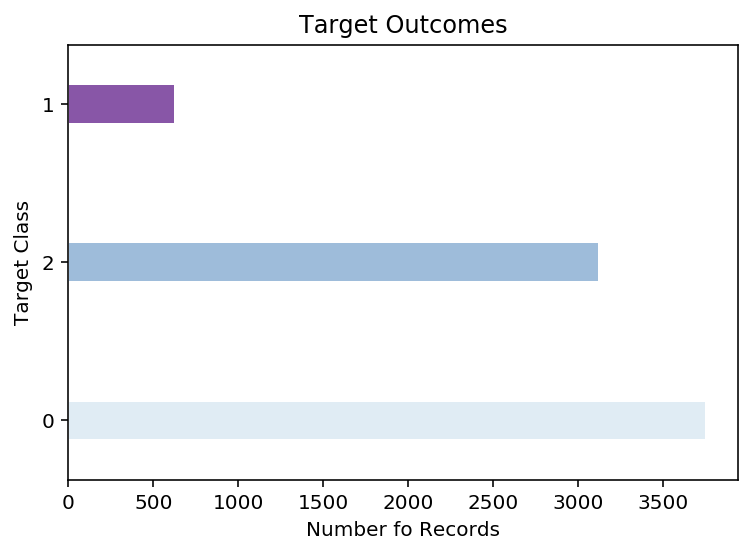

In [4]:
# Plot a barplot of the target clasees in our training set (1 = posinous, 0 = eatable by humans)
pd.Series(train_y).value_counts().plot.barh(grid=False, color=['#e0ecf4','#9ebcda','#8856a7'], width=0.25,edgecolor='w')
plt.title('Target Outcomes')
plt.ylabel('Target Class')
plt.xlabel('Number fo Records');

### Calculate Weights

In [5]:
# Compute the sample weights, weights have only been computed based on the training target values
weights = compute_sample_weight(class_weight='balanced', y=train_y)
pd.Series(weights).head(10)

0   0.801
1   0.666
2   0.666
3   0.801
4   0.666
5   0.801
6   0.666
7   0.666
8   3.987
9   0.801
dtype: float64

### Fit the Model

In [6]:
# Pass weight into fit paramter
lg_model = LogisticRegression(C=10000)
lg_model.fit(train_x, train_y, sample_weight=weights)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Pass Weights into Grid Search

In [8]:
grid = {'C':list(range(10,100,20))}
random_search = GridSearchCV(estimator=lg_model, 
                                   param_grid = grid, 
                                   scoring = 'accuracy', 
                                   n_jobs=-1, refit=True,
                                   cv = 5,
                                   return_train_score=True,
                                   fit_params= {'sample_weight':weights})

# Fit the randomized search model with our data
random_search.fit(train_x,train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={'sample_weight': array([0.80077, 0.66649, ..., 0.66649, 0.80077])},
       iid=True, n_jobs=-1, param_grid={'C': [10, 30, 50, 70, 90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

### General Notes

- For grid searching the fit_params parameter in the sklearn 0.20 and up has been moved to the 1`fit` method. I am using sklearn 0.19 for this example.
- You can feed in custom  weights into the compute sample weights function, but is best to just use 'balanced' for most use cases
- Again the returned array already has weight as applied to original y value.

### Sources

- http://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_sample_weight.html

Author: Kavi Sekhon